In [245]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd

place = 'Piedmont, CA, USA'
G = ox.graph_from_place(place, network_type='drive')

nodes, streets = ox.graph_to_gdfs(G)
streets.head()


osmid          name      highway  oneway reversed  \
u        v        key                                                          
53017091 53064327 0      6345781   Rose Avenue  residential   False    False   
         53075599 0      6345781   Rose Avenue  residential   False     True   
53018397 53018399 0      6327298   Lake Avenue  residential   False    False   
         53018411 0    196739937  Linda Avenue     tertiary   False    False   
         53097980 0    196739937  Linda Avenue     tertiary   False     True   

                        length  \
u        v        key            
53017091 53064327 0    230.124   
         53075599 0    122.235   
53018397 53018399 0    121.096   
         53018411 0     37.803   
         53097980 0     99.976   

                                                                geometry  \
u        v        key                                                      
53017091 53064327 0    LINESTRING (-122.24760 37.82625, -122.24750 37...   
         53075599 0    LINESTRING (-122.24760 37.82625, -122.24771 37...   
53018397 53018399 0    LINESTRING (-122.24719 37.82422, -122.24712 37...   
         53018411 0    LINESTRING (-122.24719 37.82422, -122.24713 37...   
         53097980 0    LINESTRING (-122.24719 37.82422, -122.24773 37...   

                      lanes maxspeed bridge junction  
u        v        key                                 
53017091 53064327 0     NaN      NaN    NaN      NaN  
         53075599 0     NaN      NaN    NaN      NaN  
53018397 53018399 0     NaN      NaN    NaN      NaN  
         53018411 0     NaN      NaN    NaN      NaN  
         53097980 0     NaN      NaN    NaN      NaN

In [257]:
import networkx as nx
from geopy.distance import geodesic

import operator

import igraph as ig
import networkx as nx
import numpy as np
import osmnx as ox

# print(ox.__version__)
# print(ig.__version__)

weight = "length"

# create networkx graph
G_nx = ox.graph_from_place("Piedmont, CA, USA", network_type="drive")
osmids = list(G_nx.nodes)
G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G_nx.nodes, osmids)}
nx.set_node_attributes(G_nx, osmid_values, "osmid")

# convert networkx graph to igraph
G_ig = ig.Graph(directed=True)
G_ig.add_vertices(G_nx.nodes)
G_ig.add_edges(G_nx.edges())
G_ig.vs["osmid"] = osmids
G_ig.es[weight] = list(nx.get_edge_attributes(G_nx, weight).values())
assert len(G_nx.nodes()) == G_ig.vcount()
assert len(G_nx.edges()) == G_ig.ecount()

# Set the source and target coordinates
source_coordinates = (37.827474, -122.233546)
target_coordinates = (37.822207, -122.229432)

# Find the nearest nodes in the graph to the specified coordinates
source = min(G_nx.nodes, key=lambda node: geodesic((G_nx.nodes[node]['y'], G_nx.nodes[node]['x']), source_coordinates).kilometers)
target = min(G_nx.nodes, key=lambda node: geodesic((G_nx.nodes[node]['y'], G_nx.nodes[node]['x']), target_coordinates).kilometers)

#shortest path
path1 = G_ig.get_shortest_paths(v=source, to=target, weights=weight)[0]
path2 = nx.shortest_path(G_nx, source, target, weight=weight)
assert path1 == path2

# lenght
path_length1 = G_ig.distances(source=source, target=target, weights=weight)[0][0]

path_length2 = nx.shortest_path_length(G_nx, source, target, weight)
assert path_length1 == path_length2



### Visualize the path from the osmnx library

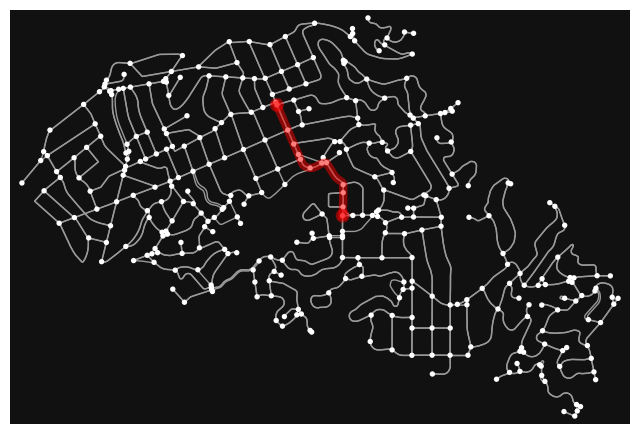

In [262]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

# Plot the graph
# fig, ax = ox.plot_graph(G_nx, bgcolor='k', node_size=15, node_color='w', edge_linewidth=0.5, show=False)

# Get the edges along the shortest path
path_edges = ox.plot_graph_route(G_nx, path1, route_color='r', orig_dest_size=100, route_linewidth=6, show=True)

# Show the plot
plt.show()


### Dijkstra Path Code

In [259]:
import networkx as nx
import heapq
from geopy.distance import geodesic

def dijkstra(graph, start, end, weight='length'):
    # Initialize distance dictionary with infinite distances for all nodes
    distances = {node: float('inf') for node in graph.nodes}
    distances[start] = 0

    # Priority queue to store (distance, node) tuples
    pq = [(0, start)]

    while pq:
        current_distance, current_node = heapq.heappop(pq)

        # If the current node has been visited with a shorter distance, skip
        if current_distance > distances[current_node]:
            continue

        # Update distances to neighbors
        for neighbor in graph.neighbors(current_node):
            edge_weight = graph.get_edge_data(current_node, neighbor).get(weight, 1)
            new_distance = distances[current_node] + edge_weight

            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor))

    # Reconstruct the path
    path = [end]
    current_node = end

    while current_node != start:
        next_node = min(graph.neighbors(current_node), key=lambda node: distances[node])
        path.append(next_node)
        current_node = next_node

    return path[::-1], distances[end]

# Set the source and target coordinates
source_coordinates = (37.827474, -122.233546)
target_coordinates = (37.822207, -122.229432)

# Find the nearest nodes in the graph to the specified coordinates
source = min(G_nx.nodes, key=lambda node: geodesic((G_nx.nodes[node]['y'], G_nx.nodes[node]['x']), source_coordinates).kilometers)
target = min(G_nx.nodes, key=lambda node: geodesic((G_nx.nodes[node]['y'], G_nx.nodes[node]['x']), target_coordinates).kilometers)

# Run the custom Dijkstra's algorithm
dijkstra_path, path_length = dijkstra(G_nx, source, target, weight='length')

# Print the result
print("Shortest Path:", dijkstra_path)
print("Path Length:", path_length)


Shortest Path: [138, 139, 140, 208, 313, 25, 32, 133, 134, 17]
Path Length: 9


### Visualize the Dijkstra path 

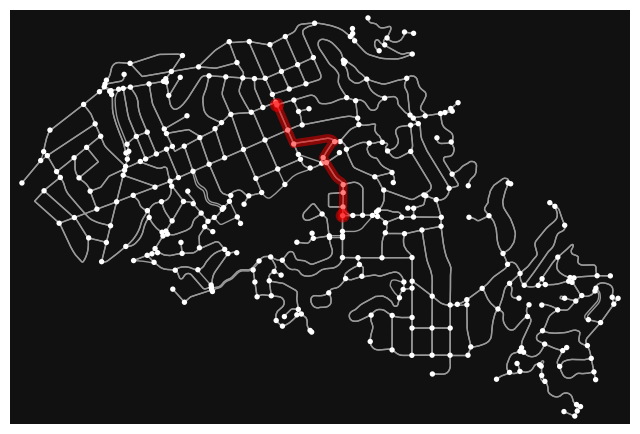

In [261]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

# Plot the graph and path
fig, ax = ox.plot_graph_route(G_nx, dijkstra_path, route_color='r', orig_dest_size=100, route_linewidth=6, show=True)

# Show the plot
plt.show()
